## Importing Data

In [1]:
!kaggle datasets download -d aslanahmedov/market-basket-analysis

Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis
License(s): copyright-authors
 88% 20.0M/22.8M [00:01<00:00, 12.9MB/s]
100% 22.8M/22.8M [00:01<00:00, 13.1MB/s]


In [2]:
!unzip market-basket-analysis.zip

Archive:  market-basket-analysis.zip
  inflating: Assignment-1_Data.csv   
  inflating: Assignment-1_Data.xlsx  


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [51]:
df = pd.read_csv('Assignment-1_Data.csv', low_memory=False, sep=";", parse_dates=['Date'])
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB


## Data Cleaning

In [53]:
# Converting the date
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M', dayfirst=True)

In [54]:
df.isnull().sum()

,0
BillNo,0
Itemname,1455
Quantity,0
Date,0
Price,0
CustomerID,134041
Country,0


In [55]:
df.dropna(subset=['Itemname'], inplace=True)

In [56]:
df.duplicated().sum()

5286

In [57]:
df.drop_duplicates(inplace=True)

In [58]:
df['Price'] = df['Price'].str.replace(',', '.').astype(np.float16)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515323 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   BillNo      515323 non-null  object        
 1   Itemname    515323 non-null  object        
 2   Quantity    515323 non-null  int64         
 3   Date        515323 non-null  datetime64[ns]
 4   Price       515323 non-null  float16       
 5   CustomerID  382811 non-null  float64       
 6   Country     515323 non-null  object        
dtypes: datetime64[ns](1), float16(1), float64(1), int64(1), object(3)
memory usage: 28.5+ MB


In [60]:
def count_outliers(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)

  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

  return len(outliers)

In [61]:
count_outliers(df, 'Price')

36771

In [62]:
upper_bound = df['Price'].quantile(0.75) + 1.5 * (df['Price'].quantile(0.75) - df['Price'].quantile(0.25))
df['Price'] = df['Price'].clip(lower=1, upper=upper_bound)

In [63]:
count_outliers(df, 'Quantity')

54539

In [64]:
upper_bound = df['Quantity'].quantile(0.75) + 1.5 * (df['Quantity'].quantile(0.75) - df['Quantity'].quantile(0.25))
df['Quantity'] = df['Quantity'].clip(lower=1, upper=upper_bound)

In [65]:
df['sales'] = df['Quantity'] * df['Price']

In [66]:
market = df.loc[:, ['BillNo', 'Itemname', 'Quantity', 'Price']]

In [67]:
customer = df.loc[:, :].dropna()

In [68]:
market.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515323 entries, 0 to 522063
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   BillNo    515323 non-null  object 
 1   Itemname  515323 non-null  object 
 2   Quantity  515323 non-null  float64
 3   Price     515323 non-null  float64
dtypes: float64(2), object(2)
memory usage: 19.7+ MB


In [69]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382811 entries, 0 to 522063
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   BillNo      382811 non-null  object        
 1   Itemname    382811 non-null  object        
 2   Quantity    382811 non-null  float64       
 3   Date        382811 non-null  datetime64[ns]
 4   Price       382811 non-null  float64       
 5   CustomerID  382811 non-null  float64       
 6   Country     382811 non-null  object        
 7   sales       382811 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 26.3+ MB


## EDA

In [70]:
df.select_dtypes(include=['int', 'float', np.float16]).describe()

,Quantity,Price,CustomerID,sales
count,515323.000000,515323.000000,382811.000000,515323.000000
mean,6.663278,3.032182,15310.347702,14.256225
std,7.129414,2.317224,1722.483516,16.473944
min,1.000000,1.000000,12346.000000,1.000000
25%,1.000000,1.250000,13928.500000,4.128906
50%,3.000000,2.080078,15249.000000,9.902344
75%,10.000000,4.128906,16820.000000,17.847656
max,23.500000,8.447266,18287.000000,198.510742


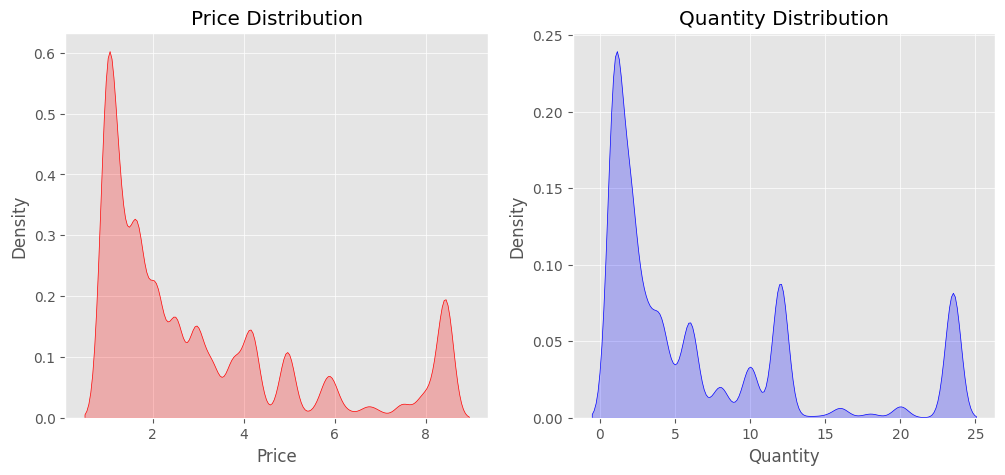

In [71]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.kdeplot(data=df, x='Price', fill=True, color='red')
plt.title('Price Distribution')
plt.subplot(122)
sns.kdeplot(data=df, x='Quantity', fill=True, color='blue')
plt.title('Quantity Distribution')
plt.show()

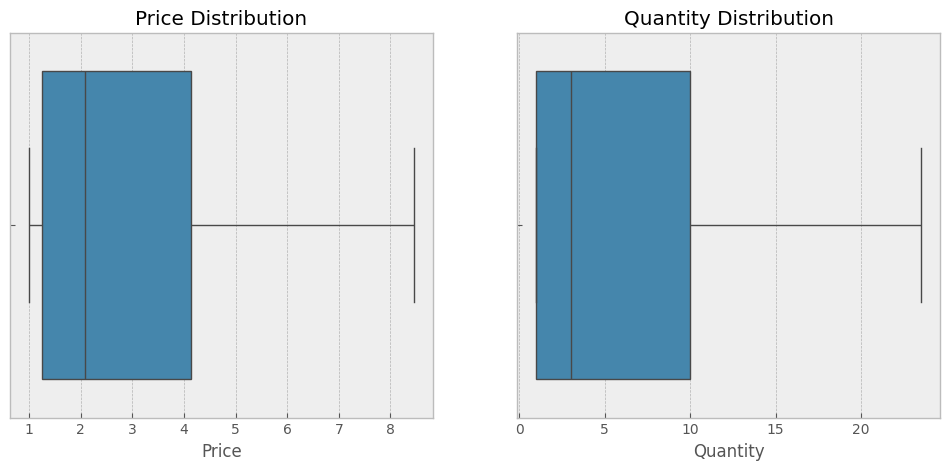

In [72]:
plt.style.use('bmh')
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.boxplot(data=df, x='Price')
plt.title('Price Distribution')
plt.subplot(122)
sns.boxplot(data=df, x='Quantity')
plt.title('Quantity Distribution')
plt.show()

In [73]:
df['Country'].value_counts().to_frame().style.background_gradient(cmap='crest')

,count
Country,
United Kingdom,480947
Germany,9027
France,8393
Spain,2480
Netherlands,2363
Belgium,2031
Switzerland,1959
Portugal,1492
Australia,1184


In [74]:
# Number of uniqe items

df['Itemname'].nunique()

4185

<ipython-input-75-6bc5011ae994>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20.values, y=top_20.index, palette='crest')


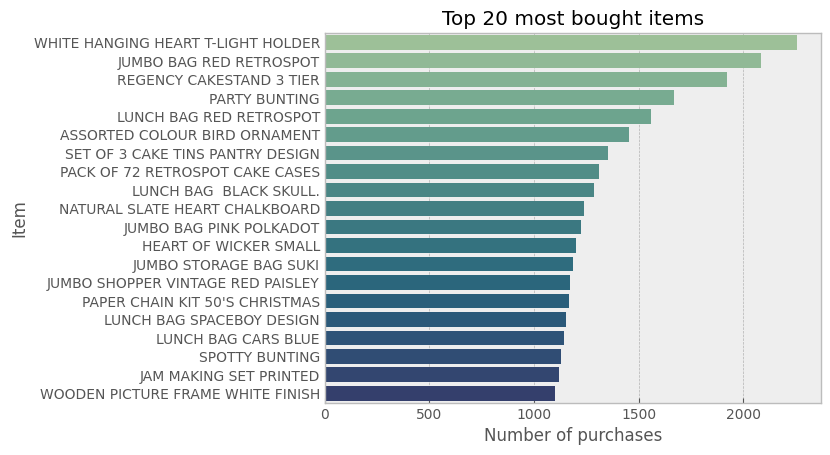

In [75]:
# Top 20 most bought items

top_20 = market.groupby('Itemname')['BillNo'].count().sort_values(ascending=False).head(20)
sns.barplot(x=top_20.values, y=top_20.index, palette='crest')
plt.xlabel('Number of purchases')
plt.ylabel('Item')
plt.title('Top 20 most bought items')
plt.show()

<ipython-input-76-624d2b2f95c1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_sals_country.values, y=avg_sals_country.index, palette='crest')


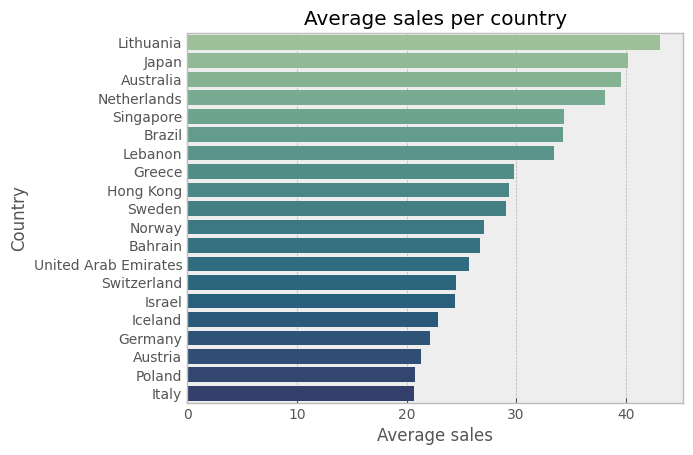

In [76]:
avg_sals_country = df.groupby('Country')['sales'].mean().sort_values(ascending=False).head(20)
sns.barplot(x=avg_sals_country.values, y=avg_sals_country.index, palette='crest')
plt.xlabel('Average sales')
plt.ylabel('Country')
plt.title('Average sales per country')
plt.show()

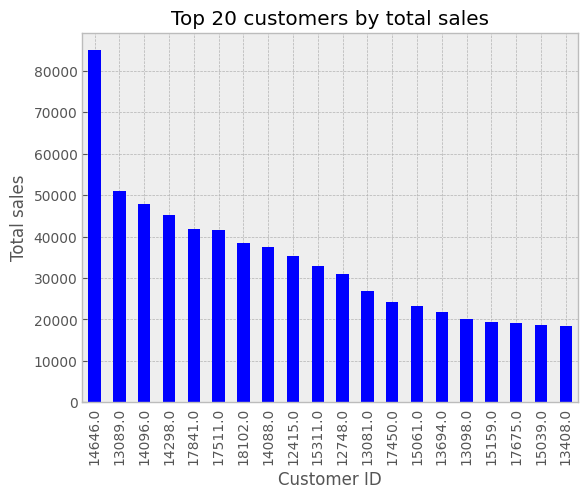

In [77]:
customer.groupby('CustomerID')['sales'].sum().sort_values(ascending=False).head(20).plot(kind='bar', color='blue')
plt.xlabel('Customer ID')
plt.ylabel('Total sales')
plt.title('Top 20 customers by total sales')
plt.show()

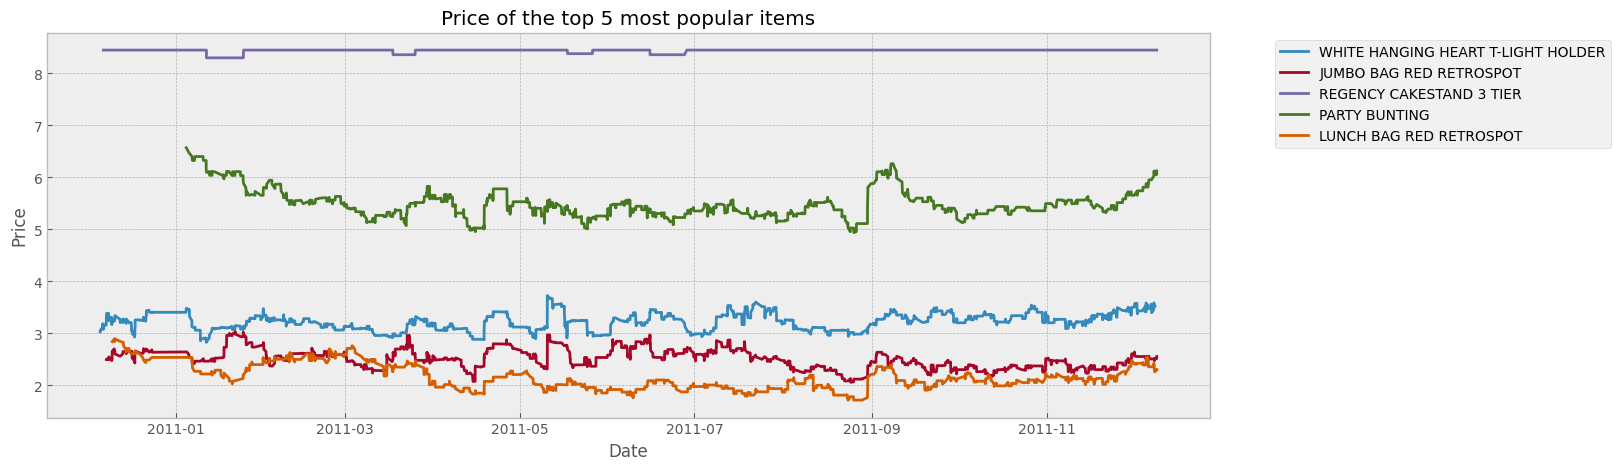

In [78]:
itemnames_5 = market.groupby('Itemname')['BillNo'].count().sort_values(ascending=False).head(5).index.values

plt.style.use('bmh')
plt.figure(figsize=(15, 5))
for name in itemnames_5:
  temp = df[df['Itemname'] == name][['Date', 'Price']]
  temp['roll'] = temp['Price'].rolling(50).mean()
  plt.plot(temp['Date'], temp['roll'], label=name)

plt.title("Price of the top 5 most popular items")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Market Basket Analysis using Apriori Algorithm

In [79]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [80]:
transactions = market.groupby('BillNo')['Itemname'].apply(list).tolist()
encoder = TransactionEncoder()
onehot = encoder.fit_transform(transactions)
df_onehot = pd.DataFrame(onehot, columns=encoder.columns_)

frequent_itemsets = apriori(df_onehot, min_support=0.02, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

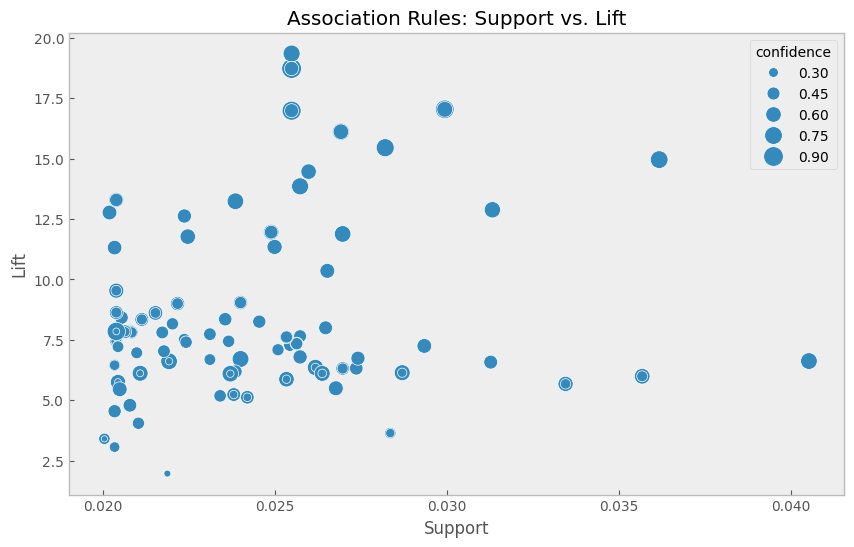

In [81]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules, x='support', y='lift', size='confidence', sizes=(20, 200))
plt.title('Association Rules: Support vs. Lift')
plt.xlabel('Support')
plt.ylabel('Lift')
plt.grid()
plt.show()

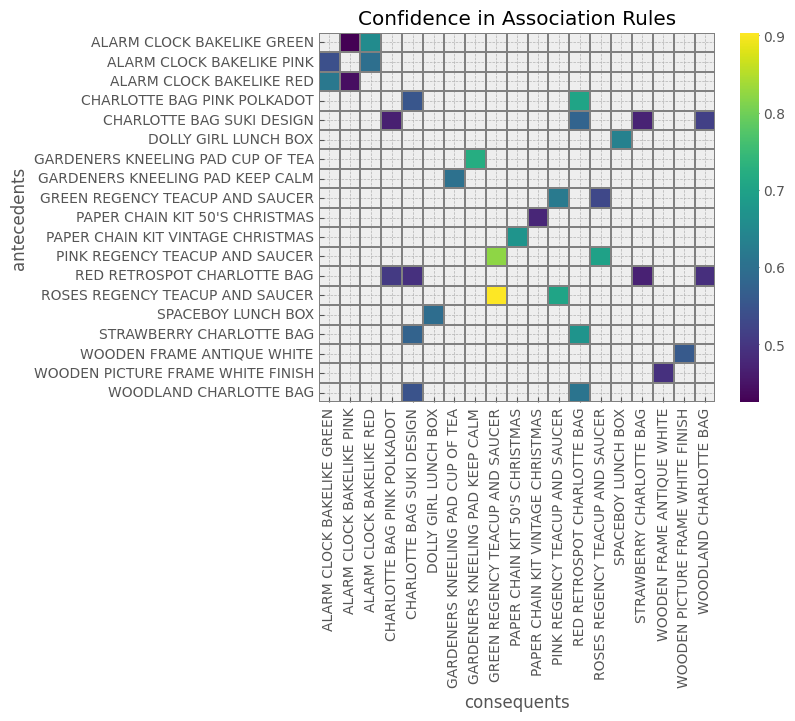

In [82]:
data = rules.sort_values(by='lift', ascending=False).head(40)
data['antecedents'] = data['antecedents'].apply(lambda x: list(x)[0])
data['consequents'] = data['consequents'].apply(lambda x: list(x)[0])
data.drop_duplicates(subset=['antecedents', 'consequents'], inplace=True)
data = data.pivot(index='antecedents', columns='consequents', values='confidence')
sns.heatmap(data, cmap='viridis', linewidths=0.01, linecolor='grey')
plt.title("Confidence in Association Rules")
plt.show()

## Customer Segmentation using K-Means

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [84]:
customer_segments = customer.groupby('CustomerID').agg({
    'sales': 'sum',
    'Quantity': 'sum',
    'Itemname': 'count'
}).reset_index()

In [85]:
customer_segments.columns = ['CustomerID', 'total_spent', 'total_quantity', 'total_items']

In [86]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_segments[['total_spent', 'total_quantity', 'total_items']])

In [87]:
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

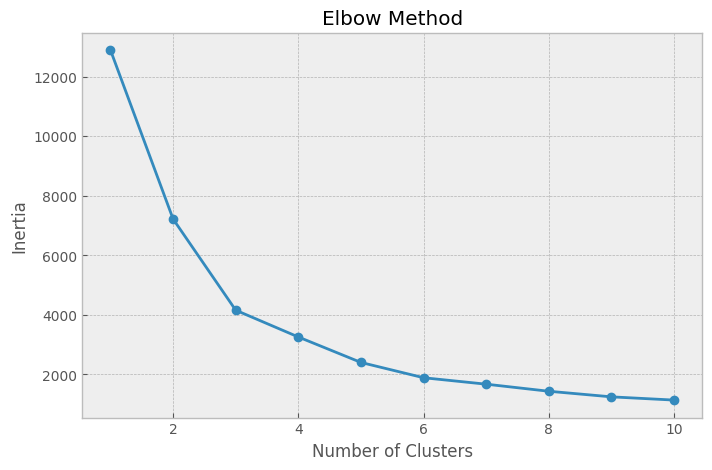

In [88]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [89]:
optimal_clusters = 6
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_segments['cluster'] = kmeans.fit_predict(scaled_data)

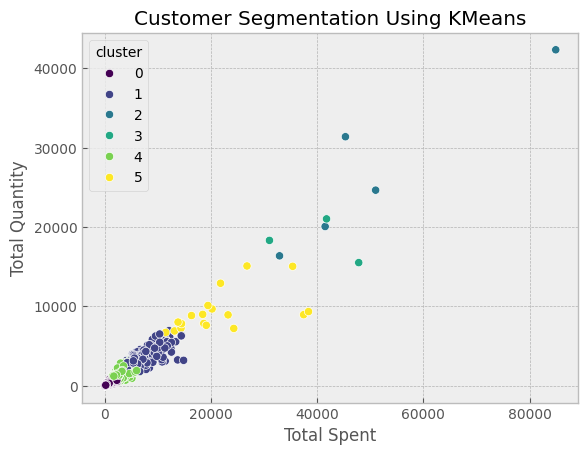

In [90]:
sns.scatterplot(data=customer_segments, x='total_spent', y='total_quantity', hue='cluster', palette='viridis')
plt.title('Customer Segmentation Using KMeans')
plt.xlabel('Total Spent')
plt.ylabel('Total Quantity')
plt.show()

In [91]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
customer_segments['PCA1'] = principal_components[:, 0]
customer_segments['PCA2'] = principal_components[:, 1]

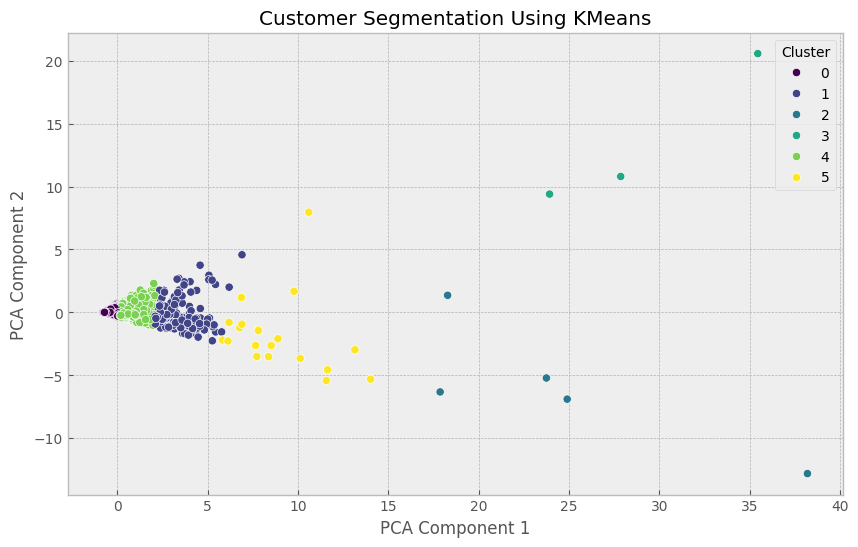

In [92]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_segments, x='PCA1', y='PCA2', hue='cluster', palette='viridis')
plt.title('Customer Segmentation Using KMeans')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

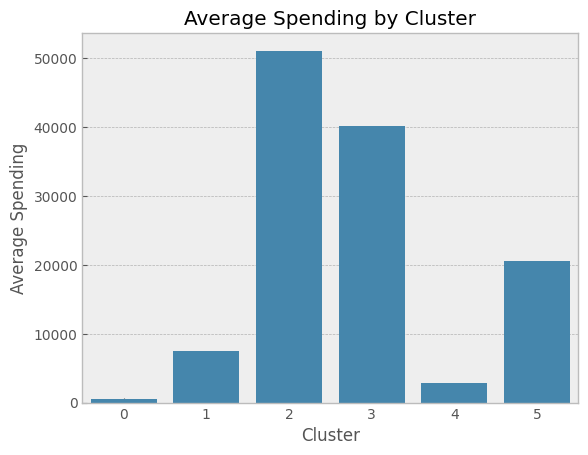

In [93]:
cluster_summary = customer_segments.groupby('cluster')['total_spent'].mean().reset_index()
sns.barplot(data=cluster_summary, x='cluster', y='total_spent')
plt.title('Average Spending by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.show()

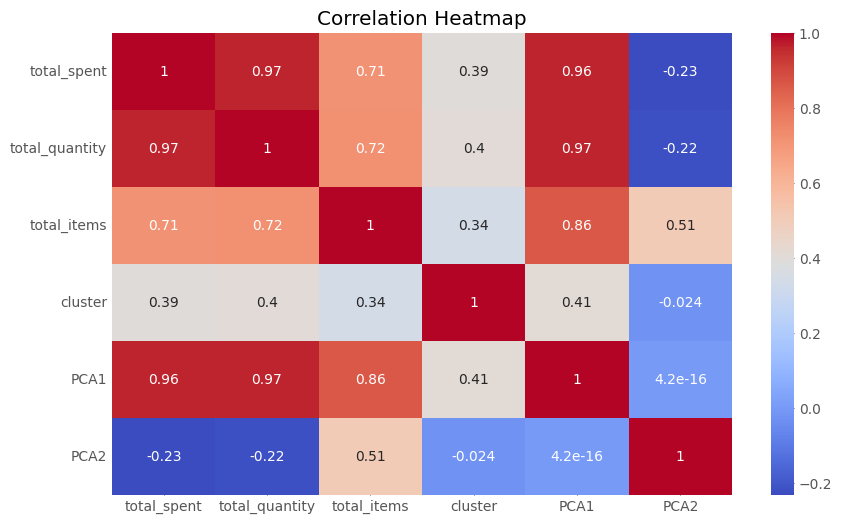

In [94]:
plt.figure(figsize=(10, 6))
sns.heatmap(customer_segments.drop(['CustomerID'], axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()